# Funções e valores auxiliares


## Calculo CDI

O cálculo do CDI em ativos de renda fixa sintética, conforme descrito no projeto TAPI do BTG Pactual, envolve várias etapas matemáticas:

**Taxa Interna de Retorno (TIR):** A TIR é calculada com base na diferença entre o preço de um contrato a termo e o preço de uma negociação à vista de uma ação. Matematicamente, é expressa como:

$TIR = \frac{Preço \ Médio \ Venda}{Preço \ Médio \ Compra} - 1$

**Anualização da TIR:** Para comparar essa taxa com o CDI, que é uma taxa anual, a TIR é anualizada. A fórmula para anualizar a TIR é:

$\text{TIR ANUALIZADA} = (1 + TIR)^{\frac{252}{\text{dias úteis}}} - 1 $

Aqui, "252" representa o número de dias úteis em um ano e "dias úteis" é o número de dias úteis entre a data da operação e o vencimento do contrato a termo.

**Cálculo do %CDI:** Por fim, a rentabilidade do ativo em termos de %CDI é calculada comparando a TIR anualizada com a taxa anualizada do DI (Depósito Interbancário) para o período:

$ \text{%CDI} = \frac{\text{TIR Anualizada}}{\text{Taxa Anualizada do DI}} \times 100\% $



In [2]:
def calcular_cdi(dias_uteis, preco_medio_compra, preco_medio_venda, taxa_di):
    rentabilidade = ((preco_medio_venda / preco_medio_compra) - 1)
    rentabilidade_anualizada = ((1 + rentabilidade) ** (252 / dias_uteis)) - 1

    cdi = (rentabilidade_anualizada / taxa_di) * 100


    return cdi

In [3]:
# Teste de Sanidade
cdi = calcular_cdi(19, 58.36317, 58.946802, 0.11295)
cdi

124.9024958621961

In [4]:
# Teste de Sanidade
cdi = calcular_cdi(19, 58.44, 58.946802, 0.11295)
cdi

107.42823894120413

## Avaliação do Desempenho por Faixa CDI

A fim de otimizar a taxa do CDI em torno dos 100% em nossas combinações, optamos por descrever um método que penaliza ou recompensa de acordo com faixas de CDI.

1º Caso: $100 ≤ CDI ≤ 105$
Para este caso, estaremos recompensando o agente com um valor constante de 1.

2º Caso: $105 < CDI < 120$
Neste caso, aplicamos uma recompensa ponderada, utilizando a distância entre o valor obtido e nosso alvo de CDI para dividir a recompensa constante de 1.

3º caso:
Casos onde o CDI ultrapassa essas limitações, tanto para valores acima como abaixo, será penalizada com um valor constante de -1.

Além do mais, analisamos a variância dos resultados, afim de mitigar a transferência de riqueszas. A variância tem um papel crucial na identificação e mitigação da transferência de riquezas. Matematicamente, a variância (σ²) de um conjunto de valores é calculada como:

$ \sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 $

onde:
- $( x_i )$ é cada valor individual no conjunto de dados (por exemplo, os valores de CDI para diferentes combinações),
- $( \mu )$ é a média desses valores,
- $( N )$ é o número total de valores.


Portanto, ao considerar a variância na função de recompensa, é possível desenvolver uma abordagem mais equilibrada e menos arriscada para a otimização do CDI, mitigando efetivamente a transferência de riquezas.

Ademais, também valorizamos o fracionamentos de ativos comprados, visando a melhor combinação possível.

In [5]:
def avaliar_cdi_e_variancia(cdi_novo, VALOR_BOM_CDI, MAX_VALOR_BOM_CDI, CONSTANTE_RECOMPENSA, variancia_nova, variancia_antiga, fracionado):
    recompensa = 0

    if VALOR_BOM_CDI <= cdi_novo <= MAX_VALOR_BOM_CDI:
        recompensa += CONSTANTE_RECOMPENSA

    elif MAX_VALOR_BOM_CDI < cdi_novo < 120:
        recompensa += CONSTANTE_RECOMPENSA / (cdi_novo - MAX_VALOR_BOM_CDI)

    if fracionado:
      recompensa += CONSTANTE_RECOMPENSA

    if (variancia_nova and variancia_antiga) is not None and (variancia_nova > variancia_antiga):
      recompensa += CONSTANTE_RECOMPENSA

    return recompensa

# Função de recompensa 1

A primeira função de recompensa, utilza como base a premissa anterior, utilizando a lógica das faias de CDI.


In [6]:
def recompensa_1(quantidade_acoes_adicionadas, preco_medio_venda, preco_medio_compra, variancia_antiga, cdi_antigo, taxa_di, preco_acao_nova, fracionado):
    """
    :param quantidade_acoes_adicionadas: Quantidade de ações adicionadas até o momento.
    :param preco_medio_venda: Preço médio de venda.
    :param preco_medio_compra: Preço médio de compra.
    :param variancia_antiga: Variância antiga.
    :param cdi_antigo: CDI antigo.
    :param taxa_di: Taxa DI.
    :param preco_acao_nova: Preço da nova ação.
    :param fracionado: Booleano indicando se é fracionado.
    :return: Valor de recompensa calculado.
    """
    CONSTANTE_RECOMPENSA = 1
    VALOR_BOM_CDI = 100
    MAX_VALOR_BOM_CDI = 105
    PENALIDADE = 1
    recompensa = 1e-3

    cdi_novo = calcular_cdi(19, preco_medio_compra, preco_medio_venda, taxa_di)

    distancia_cdi_antiga = abs(cdi_antigo - VALOR_BOM_CDI)
    distancia_cdi_nova = abs(cdi_novo - VALOR_BOM_CDI)
    variancia_nova = ((variancia_antiga * (quantidade_acoes_adicionadas - 1)) + ((preco_acao_nova - preco_medio_compra)**2)) / quantidade_acoes_adicionadas

    if distancia_cdi_antiga > distancia_cdi_nova:
        recompensa += avaliar_cdi_e_variancia(cdi_novo, VALOR_BOM_CDI, MAX_VALOR_BOM_CDI, CONSTANTE_RECOMPENSA, variancia_nova, variancia_antiga, fracionado)

    elif distancia_cdi_antiga == 0 and distancia_cdi_nova == 0 and variancia_nova > variancia_antiga:
        recompensa += CONSTANTE_RECOMPENSA

    elif cdi_novo > 120 or cdi_novo < 98:
        recompensa -= PENALIDADE

    # Garantir que a recompensa esteja dentro de um intervalo razoável
    # recompensa = max(min(recompensa, 1), -1)

    return recompensa, cdi_novo, variancia_nova



## Cenários de teste para a função de recompensa 1


In [7]:
def d_variancia(variancia_antiga, variancia_nova):
  if (variancia_nova - variancia_antiga < 0) :
    return ((variancia_nova/variancia_antiga) * 100) * -1

  return (variancia_nova/variancia_antiga) * 100


In [8]:
# Cenário 1.A: CDI ideal, variância nova maior a variância antiga, não fracionado
recompensa_cenario_1, cdi_1, variancia_1 = recompensa_1(
    quantidade_acoes_adicionadas=3,
    preco_medio_venda=58.901,
    preco_medio_compra=58.391,
    variancia_antiga=0.1,
    cdi_antigo=103,
    taxa_di=0.12,
    preco_acao_nova=55.5,
    fracionado=False
)

print('\n')
print('--------------- Cenário 1.A Recompensa 1: cenário de CDI ideal, variância nova maior que a antiga, não fracionado ----------------')
print('Recompensa : ', recompensa_cenario_1)
print('CDI: ', cdi_1, '%')
print('Diferença da variância: ', d_variancia(0.1, variancia_1), '%' )

# Cenário 1.B: CDI ideal, variância nova menor a variância antiga, não fracionado
recompensa_cenario_2, cdi_2, variancia_2 = recompensa_1(
    quantidade_acoes_adicionadas=3,
    preco_medio_venda=58.901,
    preco_medio_compra=58.391,
    variancia_antiga=0.5,
    cdi_antigo=103,
    taxa_di=0.12,
    preco_acao_nova=58.5,
    fracionado=False
)


print('\n')
print('--------------- Cenário 1.B Recompensa 2: cenário de CDI ideal, variância nova menor que a antiga, não fracionado ----------------')
print('Recompensa : ', recompensa_cenario_2)
print('CDI: ', cdi_2, '%')
print('Diferença da variância: ', d_variancia(0.5, variancia_2), '%' )

# Cenário 2.A: CDI ideal, mesma variância, fracionado
recompensa_cenario_3, cdi_3, variancia_3 = recompensa_1(
    quantidade_acoes_adicionadas=3,
    preco_medio_venda=58.9012,
    preco_medio_compra=58.400,
    variancia_antiga=0,
    cdi_antigo=103,
    taxa_di=0.12,
    preco_acao_nova=58.400,
    fracionado=True
)

print('\n')
print('--------------- Cenário 2.A Recompensa 1: cenário de CDI ideal, variância igual que a antiga, fracionado ----------------')
print('Recompensa : ', recompensa_cenario_3)
print('CDI: ', cdi_3, '%')
print('Diferença da variância: ', d_variancia(0.5, variancia_3), '%' )

# Cenário 2.B: CDI ideal, mesma variância, não fracionado
recompensa_cenario_4, cdi_4, variancia_4 = recompensa_1(
    quantidade_acoes_adicionadas=3,
    preco_medio_venda=58.9012,
    preco_medio_compra=58.400,
    variancia_antiga=0,
    cdi_antigo=103,
    taxa_di=0.12,
    preco_acao_nova=58.400,
    fracionado=False
)

print('\n')
print('--------------- Cenário 2.B Recompensa 2: cenário de CDI ideal, variância igual que a antiga, não fracionado ----------------')
print('Recompensa : ', recompensa_cenario_4)
print('CDI: ', cdi_4, '%')
print('Diferença da variância: ', d_variancia(0.5 , variancia_4), '%' )

# Cenário 3: CDI baixo
recompensa_cenario_5, cdi_5, variancia_5 = recompensa_1(
    quantidade_acoes_adicionadas=20,
    preco_medio_venda=59.6,
    preco_medio_compra=58,
    variancia_antiga=2,
    cdi_antigo=104,
    taxa_di=0.9,
    preco_acao_nova=51.1,
    fracionado=True
)

print('\n')
print('--------------- Cenário 3: cenário de CDI baixo ----------------')
print('Recompensa : ', recompensa_cenario_5)
print('CDI: ', cdi_5, '%')



# Cenário 4: CDI alto
recompensa_cenario_6, cdi_6, variancia_6 = recompensa_1(
    quantidade_acoes_adicionadas=20,
    preco_medio_venda=59.6,
    preco_medio_compra=55,
    variancia_antiga=2,
    cdi_antigo=104,
    taxa_di=0.9,
    preco_acao_nova=51.1,
    fracionado=True
)

print('\n')
print('--------------- Cenário 4: cenário de CDI alto ----------------')
print('Recompensa : ', recompensa_cenario_6)
print('CDI: ', cdi_6, '%')



--------------- Cenário 1.A Recompensa 1: cenário de CDI ideal, variância nova maior que a antiga, não fracionado ----------------
Recompensa :  2.001
CDI:  101.87949115173328 %
Diferença da variância:  2852.6269999999963 %


--------------- Cenário 1.B Recompensa 2: cenário de CDI ideal, variância nova menor que a antiga, não fracionado ----------------
Recompensa :  1.001
CDI:  101.87949115173328 %
Diferença da variância:  -67.45873333333337 %


--------------- Cenário 2.A Recompensa 1: cenário de CDI ideal, variância igual que a antiga, fracionado ----------------
Recompensa :  2.001
CDI:  100.01177284573097 %
Diferença da variância:  -0.0 %


--------------- Cenário 2.B Recompensa 2: cenário de CDI ideal, variância igual que a antiga, não fracionado ----------------
Recompensa :  1.001
CDI:  100.01177284573097 %
Diferença da variância:  -0.0 %


--------------- Cenário 3: cenário de CDI baixo ----------------
Recompensa :  -0.999
CDI:  48.2950198561134 %


--------------- Cenário

Avaliando os cenários propostos, é possível verificar que as funções de recompensa estão performando de maneira adequada:

1. Os cenários 1 e 2 propuseram um CDI ideal, avaliando como os parâmetros de fracionamento mudariam a recompensa. É visto que o fracionamento e uma maior variância resultam em um aumento constante da recompensa.

2. Dados os cenários de alto e baixo CDI, são irrelevantes os parâmetros de fracionamento e variância, visto que o objetivo principal não foi alcançado.

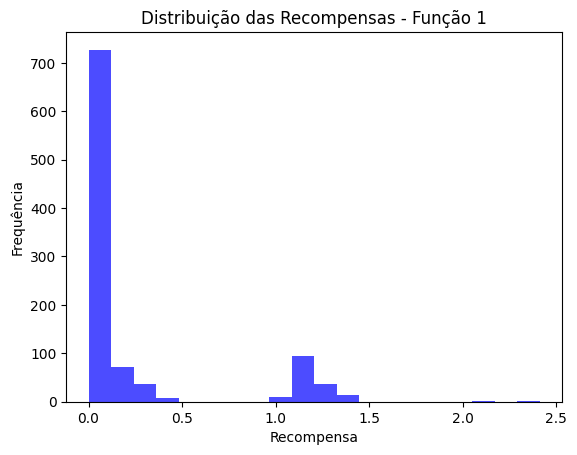

Média das Recompensas: 0.21908421812630582
Média dos CDIs: 113.53986011888391
Média da Variância:  0.09953257898098006 



0.4340398243388826

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def testar_recompensa_1(n=1000):
  # Gerando dados aleatórios para os parâmetros
  preco_medio_compra = np.random.uniform(58.44, 58.387, n)
  preco_medio_venda = 58.946802
  cdi_antigo = np.random.uniform(100, 120, n)
  taxa_di = 0.11295
  fracionado = np.random.choice([True, False], n)
  variancia_antiga = np.random.uniform(0.0, 0.3, n)
  quantidade_acoes_adicionadas = np.random.randint(1, 10, n)
  preco_acao_nova = np.random.uniform(58.44, 58.387, n)

  recompensas = []
  cdis = []
  variancias = []

  for i in range(n):
      recompensa, cdi, variancia = recompensa_1(quantidade_acoes_adicionadas[i], preco_medio_venda, preco_medio_compra[i], variancia_antiga[i], cdi_antigo[i], taxa_di,  preco_acao_nova[i], fracionado[i])
      recompensas.append(recompensa)
      cdis.append(cdi)
      variancias.append(variancia)

  return recompensas, cdis, variancias

# Testando a função de recompensa_1
recompensas, cdis, variancias = testar_recompensa_1()

# Calculando métricas
media_recompensa_1 = np.mean(recompensas)
desvio_padrao_recompensa_1 = np.std(recompensas)


# Calculando métricas
media_recompensa_2 = np.mean(cdis)

# Calculando métricas
media_recompensa_3 = np.mean(variancias)


# Gerando gráficos
plt.hist(recompensas, bins=20, color='blue', alpha=0.7)
plt.title('Distribuição das Recompensas - Função 1')
plt.xlabel('Recompensa')
plt.ylabel('Frequência')
plt.show()

# Exibindo métricas
print('Média das Recompensas:', media_recompensa_1)
print('Média dos CDIs:', media_recompensa_2)
print('Média da Variância: ', media_recompensa_3, '\n')

desvio_padrao_recompensa_1

Através de valores aleatórios dentro de uma faixa de preços que permitem CDIs entre 106% e 119%, podemos mensurar como nossa função de recompensa reage ao cálculo ponderado, através da distância. Contudo, percebe-se que a variância e o corte através da distância dos CDIs desempenham um papel crucial e fazem com que a distribuição tenda a dar valores menores que 0.4.

Contudo, vale ressaltar que há necessidade de uma análise mais clínica sobre essas distribuições e analisar parâmetro por parâmetro.

# Função de Recompensa 2

Para a segunda função de recompensa, temos a mesma lógica das faixas de CDI apresentadas na função anterior. Contudo, esta não considera a abordagem da variância e apenas leva em conta o fracionamento junto ao valor do CDI. Percebe-se também que não há corte caso a distância do novo CDI seja maior do que o anterior.

O intuito dessa função é comparar como a variância e o corte pela disância irão afetar os resultados obtidos.

In [10]:
def recompensa_2(preco_medio_venda, preco_medio_compra, cdi_antigo, taxa_di, fracionado):
  """
  :param preco_medio_venda: Preço médio de venda.
  :param preco_medio_compra: Preço médio de compra.
  :param cdi_antigo: CDI antigo.
  :param taxa_di: Taxa DI.
  :param fracionado: Booleano indicando se é fracionado.
  :return: Valor de recompensa calculado.
  """
  CONSTANTE_RECOMPENSA = 1
  VALOR_BOM_CDI = 100
  MAX_VALOR_BOM_CDI = 105
  PENALIDADE = 1
  recompensa = 1e-3

  cdi_novo = calcular_cdi(19, preco_medio_compra, preco_medio_venda, taxa_di)
  recompensa += avaliar_cdi_e_variancia(cdi_novo, VALOR_BOM_CDI, MAX_VALOR_BOM_CDI, CONSTANTE_RECOMPENSA, None, None, fracionado)

  if cdi_novo > 120 or cdi_novo < 98:
      recompensa -= PENALIDADE

  return recompensa, cdi_novo


## Cenários de teste para a função de recompensa 2

In [11]:
# Cenário 1.A: CDI ideal, fracionado
recompensa_cenario_1b, cdi_1b = recompensa_2(
    preco_medio_venda=58.901,
    preco_medio_compra=58.391,
    cdi_antigo=103,
    taxa_di=0.12,
    fracionado=True
)

print('\n')
print('--------------- Cenário 1.A Recompensa 1: cenário de CDI ideal, fracionado ----------------')
print('Recompensa : ', recompensa_cenario_1b)
print('CDI: ', cdi_1b, '%')

# Cenário 1.B: CDI ideal, não fracionado
recompensa_cenario_2b, cdi_2b = recompensa_2(
    preco_medio_venda=58.901,
    preco_medio_compra=58.391,
    cdi_antigo=103,
    taxa_di=0.12,
    fracionado=False
)


print('\n')
print('--------------- Cenário 1.B Recompensa 2: cenário de CDI ideal, não fracionado ----------------')
print('Recompensa : ', recompensa_cenario_2b)
print('CDI: ', cdi_2b, '%')


# Cenário 2.A: CDI alto, mesma variância, fracionado
recompensa_cenario_3b, cdi_3b = recompensa_2(
    preco_medio_venda=58.901,
    preco_medio_compra=58,
    cdi_antigo=103,
    taxa_di=0.12,
    fracionado=True
)

print('\n')
print('--------------- Cenário 2.A Recompensa 1: cenário de CDI alto, fracionado ----------------')
print('Recompensa : ', recompensa_cenario_3b)
print('CDI: ', cdi_3b, '%')


# Cenário 2.B: CDI alto, não fracionado
recompensa_cenario_4b, cdi_4b = recompensa_2(
    preco_medio_venda=58.901,
    preco_medio_compra=58,
    cdi_antigo=103,
    taxa_di=0.12,
    fracionado=False
)

print('\n')
print('--------------- Cenário 2.B Recompensa 2: cenário de CDI alto, não fracionado ----------------')
print('Recompensa : ', recompensa_cenario_4b)
print('CDI: ', cdi_4b, '%')

# Cenário 3.A: CDI baixo, fracionado
recompensa_cenario_5b, cdi_5b = recompensa_2(
    preco_medio_venda=58.901,
    preco_medio_compra=59.0,
    cdi_antigo=103,
    taxa_di=0.12,
    fracionado=True
)

print('\n')
print('--------------- Cenário 3.A: cenário de CDI baixo, fracionado ----------------')
print('Recompensa : ', recompensa_cenario_5b)
print('CDI: ', cdi_5b, '%')



# Cenário 3.B: CDI baixo, não fracionado
recompensa_cenario_6b, cdi_6b = recompensa_2(
    preco_medio_venda=59.6,
    preco_medio_compra=59,
    cdi_antigo=104,
    taxa_di=0.9,
    fracionado=False
)

print('\n')
print('--------------- Cenário 3.B: cenário de CDI alto, não fracionado ----------------')
print('Recompensa : ', recompensa_cenario_6b)
print('CDI: ', cdi_6b, '%')



--------------- Cenário 1.A Recompensa 1: cenário de CDI ideal, fracionado ----------------
Recompensa :  2.001
CDI:  101.87949115173328 %


--------------- Cenário 1.B Recompensa 2: cenário de CDI ideal, não fracionado ----------------
Recompensa :  1.001
CDI:  101.87949115173328 %


--------------- Cenário 2.A Recompensa 1: cenário de CDI alto, fracionado ----------------
Recompensa :  0.0009999999999998899
CDI:  189.04415917916734 %


--------------- Cenário 2.B Recompensa 2: cenário de CDI alto, não fracionado ----------------
Recompensa :  -0.999
CDI:  189.04415917916734 %


--------------- Cenário 3.A: cenário de CDI baixo, fracionado ----------------
Recompensa :  0.0009999999999998899
CDI:  -18.356326596703497 %


--------------- Cenário 3.B: cenário de CDI alto, não fracionado ----------------
Recompensa :  -0.999
CDI:  15.957738137394392 %


Avaliando os cenários propostos, é possível verificar que as funções de recompensa estão performando de maneira adequada:

1. O cenário 1 propôs um CDI ideal, avaliando como o parâmetro de fracionamento mudaria a recompensa. É visto que o fracionamento resulta em um aumento constante da recompensa.

2. Como a distância não está sendo considerada, é interessante perceber como, de fato, os valores para o fracionamento impactam muito mais na função de recompensa.unção recompensa.

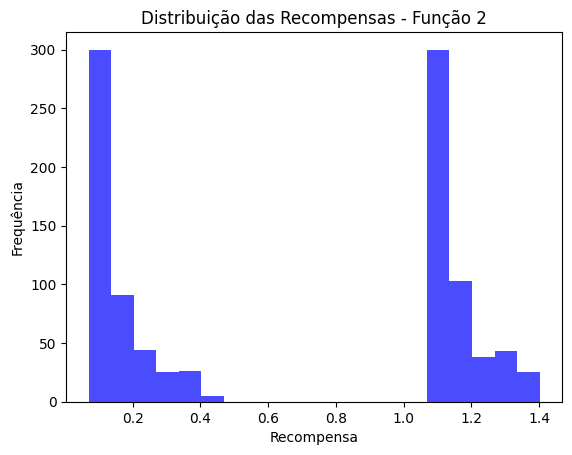

Média das Recompensas: 0.658460234162671
Média dos CDIs: 113.52482517998601


0.508329046748902

In [12]:
def testar_recompensa_2(n=1000):
  # Gerando dados aleatórios para os parâmetros
  preco_medio_compra = np.random.uniform(58.44, 58.387, n)
  preco_medio_venda = 58.946802
  cdi_antigo = np.random.uniform(100, 120, n)
  taxa_di = 0.11295
  fracionado = np.random.choice([True, False], n)

  recompensas = []
  cdis = []
  variancias = []

  for i in range(n):
      recompensa, cdi = recompensa_2(preco_medio_venda, preco_medio_compra[i], cdi_antigo[i], taxa_di,  fracionado[i])
      recompensas.append(recompensa)
      cdis.append(cdi)

  return recompensas, cdis

# Testando a função de recompensa_1
recompensas, cdis = testar_recompensa_2()

# Calculando métricas
media_recompensa_1 = np.mean(recompensas)
desvio_padrao_recompensa_1 = np.std(recompensas)


# Calculando métricas
media_recompensa_2 = np.mean(cdis)



# Gerando gráficos
plt.hist(recompensas, bins=20, color='blue', alpha=0.7)
plt.title('Distribuição das Recompensas - Função 2')
plt.xlabel('Recompensa')
plt.ylabel('Frequência')
plt.show()

# Exibindo métricas
print('Média das Recompensas:', media_recompensa_1)
print('Média dos CDIs:', media_recompensa_2)

desvio_padrao_recompensa_1

Aqui está uma distribuição de recompensas para os valores que estão entre a faixa de 106% a 120% do CDI. É perceptível, portanto, que o corte por distâncias e variância tendem a proporcionar valores de recompensa menores.

# Função de recompensa 3

A terceira função levaria em consideração a criação de um segundo agente. Este agente, seria responsável por pegar combinações que estejam elegíveis para trocarem ações entre si, o propósito da troca seria melhorar as valores de CDI dessas combinações e garantir que sua dispersão entre uma e a outra seja menor.

A recompensa será atribuida por um valor constante **1** caso haja melhora nos valores das combinações, de modo que a maior recompensa seja dada as rentabilidades que atendem a faixa **[100, 105]** , que no caso, essa seria nossa faixa de valor ótimo. Outrora, para valores entre **[106, 120]** seria feito uma ponderação de recompensa, ou seja quanto mais perto do 100 haveria maior recompensa.

Por fim, caso a troca não for favorável para as combinações, ocorre uma penalidade de valor constante **-1**;

In [13]:
def recompensa_3(cdi_maior, cdi_maior_pos_troca, cdi_menor, cdi_menor_pos_troca):
  """
  :param cdi_maior : cdi pré troca.
  :param cdi_maior_pos_troca : cdi pós troca.
  :param cdi_menor : cdi pré troca.
  :param cdi_menor_pos_troca : cdi pós troca.
  :return: Valor de recompensa calculado.
  """
  MAX_VALOR_ACEITAVEL_CDI = 120
  CONSTANTE_RECOMPENSA = 1
  VALOR_BOM_CDI = 100
  MAX_VALOR_BOM_CDI = 105
  PENALIDADE = 1
  recompensa = 1e-3

  if cdi_maior_pos_troca < cdi_maior and cdi_menor < cdi_menor_pos_troca:
    if VALOR_BOM_CDI <= cdi_maior_pos_troca <= MAX_VALOR_BOM_CDI:
      recompensa += 1

    elif MAX_VALOR_BOM_CDI < cdi_maior_pos_troca <= 120:
      recompensa += CONSTANTE_RECOMPENSA * (abs(cdi_maior - cdi_maior_pos_troca)/100)

    if VALOR_BOM_CDI <= cdi_menor_pos_troca <= MAX_VALOR_BOM_CDI:
      recompensa += 1

    elif MAX_VALOR_BOM_CDI < cdi_menor_pos_troca <= 120:
      recompensa += CONSTANTE_RECOMPENSA * (abs(cdi_menor - cdi_menor_pos_troca)/100)

  else:
    recompensa -= PENALIDADE

  return recompensa





## Cenários de Teste

### Cenário Positivo

Após a troca de ações entre as combinações, houve diminuição da dispersão entre elas, visto que uma das combinações trouxe uma rentabilidade que ainda estava na faixa de valor ótimo.

No caso, o teste estava buscando recompensar a diminuição do CDI 108 para 107 e da permanência do CDI 103 para 104 ainda se mantendo na faixa de valores ótimos, que no caso, é dentre 100 até 105.

In [14]:
resultado = recompensa_3(108, 107, 103, 104)
print(resultado)

1.011


### Cenário Positivo

Após as trocas de ações entre as combinações, houve um impacto positivo, devido a rentabilidade de maior valor conseguir se estabilizar e se encaixar na faixa de valor ótimo de CDI, no caso, houve mudança de 106 para 105.

Outrora, é importante salientar, que a outra combinação teve sua rentabilidade ainda permanecendo dentro da faixa de valor ótimo de CDI, ou seja, de 103 para 104.

In [15]:
resultado = recompensa_3(106, 105, 103, 104)
print(resultado)

2.001


### Cenário Negativo

A partir das trocas, as rentabilidades das duas combinações tiveram impactos negativos. No sentido de que a primeira combinação em que havia necessidade de diminuição, houve aumento, e a segunda combinação invés de aumento houve diminuição.

Consequentemente, houve maior dispersão entre as rentabilidades, e a situação se agravou, devido a uma das rentabilidades sair da faixa de valor ótimo, no caso, foi de 100 para 99.

In [16]:
resultado = recompensa_3(107, 108, 100, 99)
print(resultado)

-0.999


# Função de Recompensa 4

A função de recompensa 4 é projetada para avaliar e incentivar a eficiência no tempo. A ideia central é premiar o agente se ele conseguir alcançar um desempenho (medido pelo CDI) em um tempo igual ou menor do que o tempo anterior.


In [20]:
def recompensa_4(cdi_novo, cdi_antigo, tempo_final, tempo_anterior):
  CONSTANTE_RECOMPENSA = 1
  VALOR_BOM_CDI = 100
  recompensa = 1e-3


  distancia_cdi_antiga = abs(cdi_antigo - VALOR_BOM_CDI)
  distancia_cdi_nova = abs(cdi_novo - VALOR_BOM_CDI)

  if (distancia_cdi_nova <= distancia_cdi_antiga):
    if tempo_final <= tempo_anterior:
        recompensa += CONSTANTE_RECOMPENSA
  else:
      recompensa -= CONSTANTE_RECOMPENSA

  return recompensa


In [21]:
# Cenário 1: Tempo Final Pior, mas Distância Melhor
cdi_novo_1 = 101
cdi_antigo_1 = 102
tempo_final_1 = 10
tempo_anterior_1 = 8
resultado_1 = recompensa_4(cdi_novo_1, cdi_antigo_1, tempo_final_1, tempo_anterior_1)

# Cenário 2: Bom Tempo Final e Distância Melhor
cdi_novo_2 = 101
cdi_antigo_2 = 103
tempo_final_2 = 7
tempo_anterior_2 = 8
resultado_2 = recompensa_4(cdi_novo_2, cdi_antigo_2, tempo_final_2, tempo_anterior_2)

# Cenário 3: Pior Distância, mas Melhor Tempo
cdi_novo_3 = 105
cdi_antigo_3 = 102
tempo_final_3 = 7
tempo_anterior_3 = 8
resultado_3 = recompensa_4(cdi_novo_3, cdi_antigo_3, tempo_final_3, tempo_anterior_3)

resultado_1, resultado_2, resultado_3


(0.001, 1.001, -0.999)